C:\Users\swara\AppData\Local\Temp\ipykernel_11520\3890237210.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


Value at Risk (VaR) for the Portfolio:
  Confidence Level         VaR
0           90.00%  ₹12,424.60
1           95.00%  ₹15,946.81
2           99.00%  ₹22,553.87


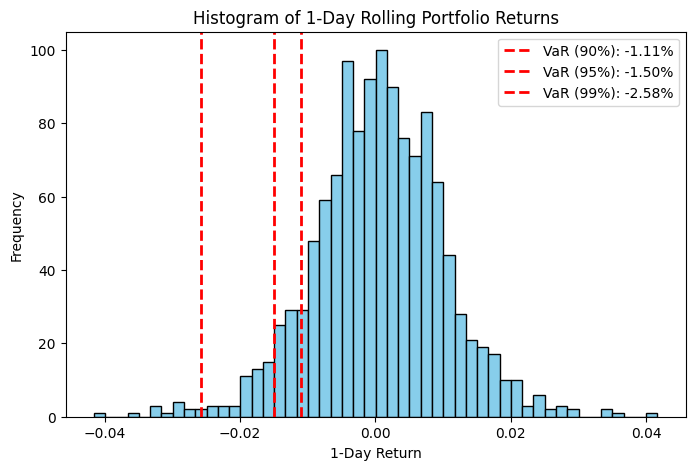

In [2]:
# ==========================
# Parametric VaR Method
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import norm
import yfinance as yf

# ------------------- CONFIGURATION -------------------
YEARS = 5
TICKERS = ['INFY.NS', 'CIPLA.NS', 'ITC.NS']
PORTFOLIO_VALUE = 1_000_000
CONFIDENCE_LEVELS = [0.90, 0.95, 0.99]
DAYS = 1
PLOT_RESULTS = True
# ------------------------------------------------------

def fetch_price_data(tickers, years):
    """Fetch adjusted closing prices for given tickers over the past `years`."""
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=years * 365)
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']
    return pd.DataFrame(prices)

def calculate_log_returns(prices):
    """Calculate daily log returns from price data."""
    log_returns = np.log(prices / prices.shift(1))
    return log_returns.dropna()

def calculate_portfolio_returns(log_returns, weights):
    """Calculate daily portfolio returns from log returns and weights."""
    return log_returns.dot(weights)

def calculate_portfolio_volatility(log_returns, weights):
    """Calculate annualized portfolio volatility using covariance matrix."""
    cov_matrix = log_returns.cov()
    return np.sqrt(weights.T @ cov_matrix @ weights)

def calculate_parametric_var(portfolio_std_dev, portfolio_value, confidence_levels):
    """Calculate Parametric (Variance-Covariance) VaR."""
    var_values = []
    for cl in confidence_levels:
        z_score = norm.ppf(1 - cl)
        var = abs(portfolio_value * (z_score * portfolio_std_dev))
        var_values.append(round(var, 2))
    return var_values

def plot_var_distribution(range_returns, confidence_levels, days):
    """Plot histogram of portfolio returns with VaR cutoffs."""
    plt.figure(figsize=(8, 5))
    plt.hist(range_returns, bins=50, color='skyblue', edgecolor='black')

    for cl in confidence_levels:
        cutoff = np.percentile(range_returns, (1 - cl) * 100)
        plt.axvline(cutoff, color='red', linestyle='dashed', linewidth=2,
                    label=f'VaR ({int(cl * 100)}%): {cutoff:.2%}')

    plt.title(f'Histogram of {days}-Day Rolling Portfolio Returns')
    plt.xlabel(f'{days}-Day Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# ------------------- MAIN SCRIPT -------------------
if __name__ == "__main__":
    # 1. Fetch prices
    prices = fetch_price_data(TICKERS, YEARS)

    # 2. Calculate log returns
    log_returns = calculate_log_returns(prices)

    # 3. Equal-weight portfolio
    weights = np.array([1 / len(TICKERS)] * len(TICKERS))

    # 4. Calculate portfolio returns & volatility
    portfolio_returns = calculate_portfolio_returns(log_returns, weights)
    portfolio_std_dev = calculate_portfolio_volatility(log_returns, weights)

    # 5. Rolling returns for plotting
    range_returns = portfolio_returns.rolling(window=DAYS).sum().dropna()

    # 6. Calculate VaR
    var_values = calculate_parametric_var(portfolio_std_dev, PORTFOLIO_VALUE, CONFIDENCE_LEVELS)

    # 7. Display results
    var_df = pd.DataFrame({
        'Confidence Level': CONFIDENCE_LEVELS,
        'VaR': var_values
    })
    # Format only the VaR column
    var_df['VaR'] = var_df['VaR'].apply(lambda x: f'₹{x:,.2f}')
    var_df['Confidence Level'] = var_df['Confidence Level'].apply(lambda x: f'{x*100:,.2f}%')

    print("\nValue at Risk (VaR) for the Portfolio:")
    print(var_df)

    # 8. Plot if enabled
    if PLOT_RESULTS:
        plot_var_distribution(range_returns, CONFIDENCE_LEVELS, DAYS)
